<a href="https://colab.research.google.com/github/glane2609/Glane/blob/main/Review_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 99.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 97.8 MB/s eta 0:00:00


In [ ]:
pip install tensorflow-text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 61.9 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-3-c16a16cb288b>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['content']=reviews_df['content'].apply(str)


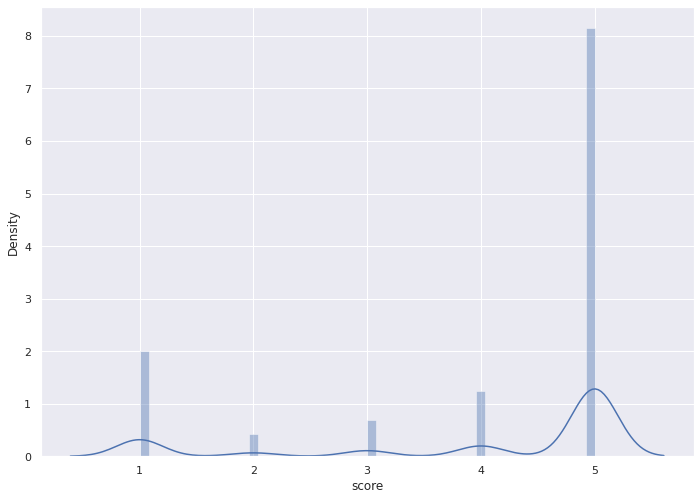

In [ ]:
#!/usr/bin/env python
# coding: utf-8

# In[2]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# In[3]:


reviews_df = pd.read_excel('collected_reviews.xlsx')    #here datasets is the folder I have in my working directory C:/Users/glane/


# In[4]:


import tensorflow_text as text
import transformers

# In[ ]:


import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense


# In[ ]:


reviews_df.isnull().sum()


# In[ ]:


reviews_df.dropna(inplace = True)


# In[ ]:


### distribution of ratings
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(reviews_df['score'])


# In[ ]:


#sns.set(rc={'figure.figsize':(11.7,8.27)})
#h = sns.countplot(x='score', data=reviews_df)
#for container in h.containers:
#    h.bar_label(container)


# In[ ]:


reviews_df= reviews_df[['content', 'score']]
reviews_df


# In[ ]:


reviews_df['content']=reviews_df['content'].apply(str)


# In[ ]:
import re
def preprocess_text(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', text)
    text = re.sub('@[^\s]+','USER', text)
    text = text.lower().replace("ё", "е")
    text = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', text)
    text = re.sub(' +',' ', text)
    text = re.sub(" \d+", " ", text)
    return text.strip()
reviews_df['content'] = [preprocess_text(t) for t in reviews_df['content']]

# In[ ]:


df_1 = reviews_df[reviews_df['score']==1]
df_2 = reviews_df[reviews_df['score']==2]
df_3 = reviews_df[reviews_df['score']==3]
df_4 = reviews_df[reviews_df['score']==4]
df_5 = reviews_df[reviews_df['score']==5]


# In[ ]:


df_1_downsampled = df_1.sample(df_2.shape[0])
df_3_downsampled = df_3.sample(df_2.shape[0])
df_4_downsampled = df_4.sample(df_2.shape[0])
df_5_downsampled = df_5.sample(df_2.shape[0])
df_balanced = pd.concat([df_1_downsampled, df_2,df_3_downsampled,df_4_downsampled,df_5_downsampled])
df_balanced.shape
df_balanced['score'].replace([1,2,3,4,5],[0,1,2,3,4],inplace =True)

# In[ ]:


df_balanced['content']=df_balanced['content'].apply(str)


# In[ ]:


from sklearn.model_selection import train_test_split
train,test = train_test_split(df_balanced, test_size=0.3, random_state=0,stratify = df_balanced['score'])
train,valid = train_test_split(train, test_size=0.2, random_state=0,stratify = train['score'])



In [ ]:
from transformers import (
    BertForSequenceClassification,    
    BertTokenizer,
    RobertaForSequenceClassification,
    RobertaTokenizer,
    AdamW)

In [ ]:
# Loading BERT base model
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", #Using BERT base model with an uncased vocab.
                                                                num_labels = 5, #number of output labels - 0,1 (binary classification)
                                                                output_attentions = False, #model doesnt return attention weights
                                                                output_hidden_states = False #model doesnt return hidden states
                                                          )
#BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
bert_model.cuda()

# Loading RoBERTa base model
roberta_model = RobertaForSequenceClassification.from_pretrained("roberta-base", #RoBERTa base model
                                                                    num_labels = 5,  #number of output labels - 0,1 (binary classification)
                                                                    output_attentions = False,  #model doesnt return attention weights
                                                                    output_hidden_states = False #model doesnt return hidden states
                                                                )
#RoBERTa tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)

# Tell pytorch to run this model on the GPU.
roberta_model.cuda()

print(' Base models loaded') 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

 Base models loaded


In [ ]:
#assigning sentences and labels to separate variables
sentences = train['content'].values
labels = train['score'].values

In [ ]:
import torch

In [ ]:
# Below function performs tokenization process as required by bert and roberta models, for a given dataset
def bert_robert_tokenization(dataset):
  sentences = df_balanced["content"].values
  labels = df_balanced["score"].values
  max_length = 256

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  bert_input_ids = []
  bert_attention_masks = []
  roberta_input_ids = []
  roberta_attention_masks = []

  sentence_ids = []
  counter = 0

  # For every sentence...
  for sent in sentences:
      #encode_plus function will encode the sentences as required by model, including tokenization process and mapping token ids
      bert_encoded_dict = bert_tokenizer.encode_plus(
                          str(sent),        #sentence              
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 256,     #Since we have seen from our analysis that majority of sentences have length less than 300.    
                          pad_to_max_length = True,    # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,  # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      roberta_encoded_dict = roberta_tokenizer.encode_plus(
                          str(sent),        #sentence
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]' tokens 
                          max_length = 256,        #Since we have seen from our analysis that majority of sentences have length less than 300.   
                          pad_to_max_length = True,     # Pad sentences to 256 length  if the length of sentence is less than max_length
                          return_attention_mask = True,   # Create attention mask
                          truncation = True,   # truncate sentences to 256 length  if the length of sentence is greater than max_length
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      # Add the encoded sentence to the list.    
      bert_input_ids.append(bert_encoded_dict['input_ids'])
      roberta_input_ids.append(roberta_encoded_dict['input_ids'])
      
      
      # Add attention mask to the list 
      bert_attention_masks.append(bert_encoded_dict['attention_mask'])
      roberta_attention_masks.append(roberta_encoded_dict['attention_mask'])
      
      
      # collecting sentence_ids
      sentence_ids.append(counter)
      counter  = counter + 1
      
      
      
   # Convert the lists into tensors.
  bert_input_ids = torch.cat(bert_input_ids, dim=0)
  bert_attention_masks = torch.cat(bert_attention_masks, dim=0)

  roberta_input_ids = torch.cat(roberta_input_ids, dim=0)
  roberta_attention_masks = torch.cat(roberta_attention_masks, dim=0)


  labels = torch.tensor(labels)
  sentence_ids = torch.tensor(sentence_ids)

  return {"Bert":[bert_input_ids, bert_attention_masks, labels], "Roberta":[roberta_input_ids, roberta_attention_masks, labels]}

In [ ]:
from torch.utils.data import TensorDataset, random_split
# function to seed the script globally
torch.manual_seed(0)

#tokenizing train set
token_dict_train = bert_robert_tokenization(train)

bert_input_ids,bert_attention_masks,labels = token_dict_train["Bert"]
roberta_input_ids, roberta_attention_masks, labels = token_dict_train["Roberta"]

#tokenizing validation set
token_dict_valid = bert_robert_tokenization(valid)

bert_input_ids_valid,bert_attention_masks_valid,labels_valid = token_dict_valid["Bert"]
roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid = token_dict_valid["Roberta"]

#tokenizing test set
token_dict_test = bert_robert_tokenization(test)

bert_input_ids_test,bert_attention_masks_test,labels_test = token_dict_test["Bert"]
roberta_input_ids_test, roberta_attention_masks_test, labels_test = token_dict_test["Roberta"]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
# Combine the training inputs into a TensorDataset.
bert_train_dataset = TensorDataset( bert_input_ids, bert_attention_masks, labels) 
roberta_train_dataset = TensorDataset(roberta_input_ids, roberta_attention_masks, labels)

# Combine the validation inputs into a TensorDataset.
bert_val_dataset = TensorDataset(bert_input_ids_valid,bert_attention_masks_valid,labels_valid)
roberta_val_dataset = TensorDataset(roberta_input_ids_valid, roberta_attention_masks_valid, labels_valid)

In [ ]:
# Combine the test inputs into a TensorDataset.
bert_test_dataset = TensorDataset(bert_input_ids_test,bert_attention_masks_test,labels_test)
roberta_test_dataset = TensorDataset(roberta_input_ids_test, roberta_attention_masks_test, labels_test)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoaders for our training - Loads the data randomly in batches of size 32
bert_train_dataloader = DataLoader(
            bert_train_dataset,  # The training samples.
            sampler = RandomSampler(bert_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

roberta_train_dataloader = DataLoader(
            roberta_train_dataset,  # The training samples.
            sampler = RandomSampler(roberta_train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# Create the DataLoaders for our validation - Loads the data in batches of size 32
bert_validation_dataloader = DataLoader(
            bert_val_dataset, # The validation samples.
            sampler = SequentialSampler(bert_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


roberta_validation_dataloader = DataLoader(
            roberta_val_dataset, # The validation samples.
            sampler = SequentialSampler(roberta_val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
# optimizers - AdamW
# here, i have used default learning rate and epsilon values for both BERT and RoBERTa
bert_optimizer = AdamW(bert_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )

roberta_optimizer = AdamW(roberta_model.parameters(),
                  lr = 5e-5, 
                  eps = 1e-8 
                )

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 5

# Total number of training steps is [number of batches] x [number of epochs]
total_steps = len(bert_train_dataloader) * epochs

# Create the learning rate scheduler.
bert_scheduler = get_linear_schedule_with_warmup(bert_optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

roberta_scheduler = get_linear_schedule_with_warmup(roberta_optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import torch

# tell pytorch to use the gpu if available
if torch.cuda.is_available():    
      
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import random
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128
# Set the seed value all over the place to make this reproducible.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
loss_values = []
for epoch_i in range(0, epochs):
    #Training 
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')
    # Measure how long the training epoch takes.
    t0 = time.time()
    # Reset the total loss for this epoch.
    total_loss = 0
    bert_model.train()
    # For each batch of training data...
    for step, batch in enumerate(bert_train_dataloader):
      #Report progress after every 40 epochs
        if step % 40 == 0 and not step == 0: 
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # print current training batch and elapsed time
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(bert_train_dataloader), elapsed))
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        bert_model.zero_grad()        
        
        outputs = bert_model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
         # model returns a tuple, extract loss value from that tuple
        loss = outputs[0]
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        bert_optimizer.step()
        
        bert_scheduler.step()
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(bert_train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    #Validation Part

    
    print("")
    print("Running Validation...")
    t0 = time.time()
    # Put the model in evaluation mode    
    bert_model.eval()
    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Evaluate data for one epoch
    for batch in bert_validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():        
           outputs = bert_model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        logits = outputs[0]
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy
        # Track the number of batches
        nb_eval_steps += 1
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:54.
  Batch    80  of    120.    Elapsed: 0:01:44.

  Average training loss: 1.46
  Training epcoh took: 0:02:34

Running Validation...
  Accuracy: 0.48
  Validation took: 0:00:55

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:50.
  Batch    80  of    120.    Elapsed: 0:01:40.

  Average training loss: 1.23
  Training epcoh took: 0:02:30

Running Validation...
  Accuracy: 0.60
  Validation took: 0:00:55

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:50.
  Batch    80  of    120.    Elapsed: 0:01:40.

  Average training loss: 1.04
  Training epcoh took: 0:02:30

Running Validation...
  Accuracy: 0.73
  Validation took: 0:00:55

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    120.    Elapsed: 0:00:50.
  Batch    80  of    120.    Elapsed: 0:01:40.

  Average training loss: 0.82
  Training epcoh took: 0:02:30

Ru

In [ ]:
bert_prediction_sampler = SequentialSampler(bert_test_dataset)
bert_prediction_dataloader = DataLoader(bert_test_dataset, sampler=bert_prediction_sampler, batch_size=batch_size)

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(bert_input_ids_test)))

# Put model in evaluation mode
bert_model.eval()

# Tracking variables 
predictions , true_labels = [], []

Predicting labels for 3,820 test sentences...


In [ ]:
# Predict 
for batch in bert_prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
 
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = bert_model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)
print('    DONE.')

    DONE.


In [ ]:
predictions_labels = [item for subitem in predictions for item in subitem]

predictions_labels = np.argmax(predictions_labels, axis=1).flatten()
predictions_labels = pd.DataFrame(predictions_labels)
predictions_labels.replace([0,1,2,3,4],[1,2,3,4,5],inplace = True)

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]
flat_true_labels = pd.DataFrame(flat_true_labels)
flat_true_labels.replace([0,1,2,3,4],[1,2,3,4,5],inplace = True)
from sklearn.metrics import classification_report

print (classification_report(predictions_labels, flat_true_labels))

              precision    recall  f1-score   support

           1       0.92      0.97      0.94       727
           2       0.85      0.89      0.87       726
           3       0.77      0.79      0.78       745
           4       0.78      0.72      0.75       830
           5       0.84      0.81      0.82       792

    accuracy                           0.83      3820
   macro avg       0.83      0.83      0.83      3820
weighted avg       0.83      0.83      0.83      3820

